In [2]:
#  this script is meant to deal with the data of 8 recognition runs and generate models saved in corresponding folder
'''
input:
    cfg.session=ses1
    cfg.modelFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/clf/"
    cfg.dataFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/"
output:
    models in cfg.modelFolder
'''


import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
from subprocess import call
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
from rtCommon.fileClient import FileInterface
import rtCommon.projectUtils as projUtils
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
cfg = cfg_loading("sub001.ses1.toml")

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading



/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them


In [18]:
'''
purpose: 
    train offline models

steps:
    load preprocessed and aligned behavior and brain data 
    select data with the wanted pattern like AB AC AD BC BD CD 
    train correspondng classifier and save the classifier performance and the classifiers themselves.

'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


def normalize(X):
    X = X - X.mean(0)
    return X

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def get_inds(X, Y, pair, testRun=None):

    inds = {}

    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label

    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                             multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]

    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X

    return inds

if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
else:
    main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

working_dir=main_dir
os.chdir(working_dir)

'''
if you read runRecording for current session and found that there are only 4 runs in the current session, 
you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
'''
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]
if len(actualRuns) < 8:
    runRecording_preDay = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session}/recognition/../runRecording.csv")
    actualRuns_preDay = list(runRecording_preDay['run'].iloc[list(np.where(1==1*(runRecording_preDay['type']=='recognition'))[0])])[-(8-len(actualRuns)):] # might be [5,6,7,8]
else: 
    actualRuns_preDay = []

assert len(actualRuns_preDay)+len(actualRuns)==8 

objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    mask = nib.load(f"{cfg.recognition_dir}chosenMask.nii.gz").get_data()
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=t if ii==0 else pd.concat([behav_data,t])

for ii,run in enumerate(actualRuns_preDay): # load behavior and brain data for previous session
    t = np.load(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/brain_run{run}.npy")
    mask = nib.load(f"{cfg.recognition_dir}chosenMask.nii.gz").get_data()
    t = t[:,mask==1]
    brain_data = np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/behav_run{run}.csv")
    behav_data = pd.concat([behav_data,t])

FEAT=brain_data.reshape(brain_data.shape[0],-1)
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}
label=[]
for curr_trial in range(META.shape[0]):
    label.append(imcodeDict[META['Item'].iloc[curr_trial]])
META['label']=label # merge the label column with the data dataframe

# Which run to use as test data (leave as None to not have test data)
testRun = 2 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

# Decide on the proportion of crescent data to use for classification
include = 1
accuracyContainer=[]


allpairs = itertools.combinations(objects,2)

# Iterate over all the possible target pairs of objects
for pair in allpairs:
    # Find the control (remaining) objects for this pair
    altpair = other(pair)

    # pull sorted indices for each of the critical objects, in order of importance (low to high)
    # inds = get_inds(FEAT, META, pair, testRun=testRun)

    # Find the number of voxels that will be left given your inclusion parameter above
    # nvox = red_vox(FEAT.shape[1], include)

    for obj in pair:
        # foil = [i for i in pair if i != obj][0]
        for altobj in altpair:

            # establish a naming convention where it is $TARGET_$CLASSIFICATION
            # Target is the NF pair (e.g. bed/bench)
            # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
            naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

            # Pull the relevant inds from your previously established dictionary 
            # obj_inds = inds[obj]

            # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
            if testRun:
                trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
            else:
                trainIX = META.index[(META['label'].isin([obj, altobj]))]
                testIX = META.index[(META['label'].isin([obj, altobj]))]

            # pull training and test data
            trainX = FEAT[trainIX]
            testX = FEAT[testIX]
            trainY = META.iloc[trainIX].label
            testY = META.iloc[testIX].label

            # # If you're selecting high-importance features, this bit handles that
            # if include < 1:
            #     trainX = trainX[:, obj_inds[-nvox:]]
            #     testX = testX[:, obj_inds[-nvox:]]

            # Train your classifier
            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                     multi_class='multinomial').fit(trainX, trainY)

            model_folder = cfg.trainingModel_dir
            # Save it for later use
            joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            print(naming, acc)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedbench_bedchair 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedbench_bedtable 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedbench_benchchair 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedbench_benchtable 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedchair_bedbench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedchair_bedtable 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedchair_chairbench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedchair_chairtable 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedtable_bedbench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedtable_bedchair 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedtable_tablebench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedtable_tablechair 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchchair_benchbed 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchchair_benchtable 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchchair_chairbed 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchchair_chairtable 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchtable_benchbed 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchtable_benchchair 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchtable_tablebed 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


benchtable_tablechair 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


chairtable_chairbed 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


chairtable_chairbench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


chairtable_tablebed 1.0
chairtable_tablebench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
print(naming)
# list(META['label'])[4:10]
np.unique(META['label'])

chairtable_tablebench


array(['bed', 'bench', 'chair', 'table'], dtype=object)

In [84]:
META.reset_index()
trainIX = META.index[(META['label'].isin(['chair'])) & (META['run_num'] != int(2))]
trainY = META.iloc[trainIX].label
print(trainY)

1     chair
6     chair
10    chair
14    chair
16    chair
      ...  
27    chair
29      bed
35    bench
37    chair
44    bench
Name: label, Length: 83, dtype: object


In [83]:
META['label'].iloc[trainIX]

1     chair
6     chair
10    chair
14    chair
16    chair
      ...  
27    chair
29      bed
35    bench
37    chair
44    bench
Name: label, Length: 83, dtype: object

In [85]:
META

,Unnamed: 0,TR,image_on,Resp,Item,isCorrect,subj,run_num,label
0,3,3,5.999537,2.0,D,True,sub001,1,bench
1,5,5,9.999614,2.0,B,True,sub001,1,chair
2,8,8,15.999709,1.0,A,True,sub001,1,bed
3,12,12,23.999743,1.0,C,True,sub001,1,table
4,15,15,29.999806,2.0,D,True,sub001,1,bench
...,...,...,...,...,...,...,...,...,...
42,130,130,260.008890,1.0,A,True,sub001,8,bed
43,132,132,264.008975,2.0,D,True,sub001,8,bench
44,134,134,268.008995,2.0,B,True,sub001,8,chair
45,137,137,274.009081,1.0,C,True,sub001,8,table


# import numpy as np
testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
np.load(f"{testDir}wang2014/0111171/output/roi24_rh.npy")

In [1]:

di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
from glob import glob
import numpy as np
subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "
    
    
testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,len(subs)))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


In [2]:
wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

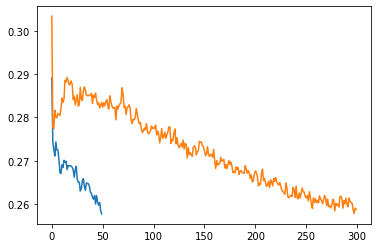

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))

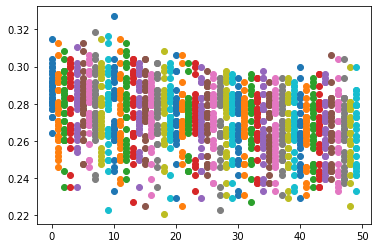

In [10]:

for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i])

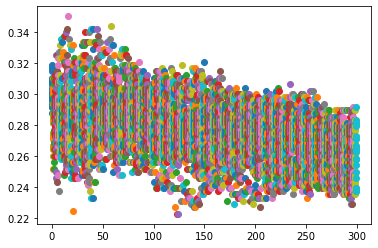

In [20]:
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i])

Text(0, 0.5, 'accuracy')

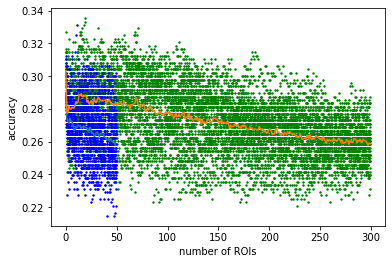

In [9]:

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))
for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)
    
plt.xlabel("number of ROIs")
plt.ylabel("accuracy")

Text(0, 0.5, 'accuracy')

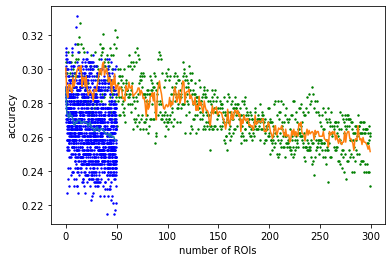

In [10]:
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,3))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")
# plt.savefig('SummaryAccuracy.png')
# next step is to use averageAggregatee.sh to cnvert things to standard space and add things together to visualize things.


In [54]:
schaeferBestSub=[]
for current_ROI in range(schaeferAcc.shape[0]):
    t=list(schaeferAcc[current_ROI])
    t.sort()
    schaeferBestSub.append([current_ROI+1,subjects[np.where(schaeferAcc[current_ROI]==t[-2])[0][0]]])


{'whiskers': [<matplotlib.lines.Line2D at 0x2b88b0aee5f8>,
 'caps': [<matplotlib.lines.Line2D at 0x2b88b0aeeba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b88b0aee390>,
 'medians': [<matplotlib.lines.Line2D at 0x2b88b0b30198>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b88b0b30470>,
 'means': []}

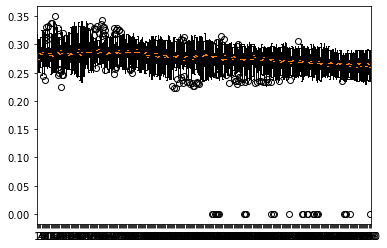

In [70]:
_=plt.boxplot(schaeferAcc.T)

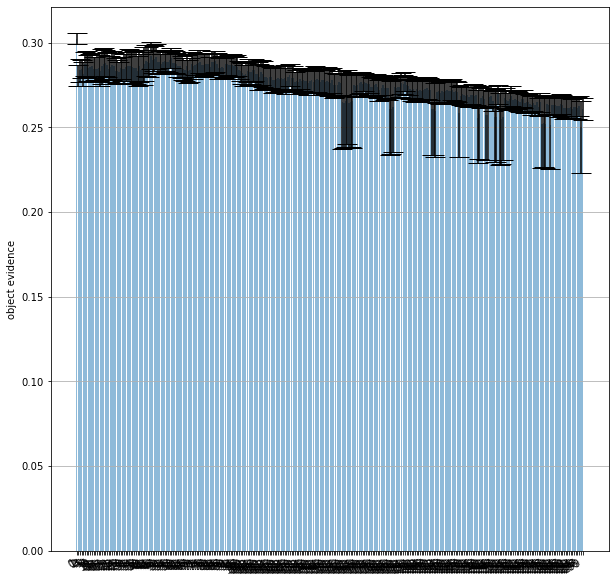

(array([0.30237321, 0.28054364, 0.28377035, 0.28441007, 0.28133162,
        0.28735715, 0.28750059, 0.28508345, 0.28579212, 0.28615865,
        0.28467863, 0.28439241, 0.28447025, 0.28514966, 0.28322526,
        0.28596854, 0.28716894, 0.28784717, 0.28665635, 0.28444697,
        0.28537398, 0.28656848, 0.2862773 , 0.28340511, 0.28313109,
        0.28260447, 0.28496925, 0.28447519, 0.28456767, 0.28535676,
        0.28603118, 0.28650366, 0.28616937, 0.2854946 , 0.28517735,
        0.28518109, 0.28348839, 0.28619687, 0.28414397, 0.28477212,
        0.28735692, 0.28944077, 0.28844442, 0.28798955, 0.2922138 ,
        0.28993943, 0.29045486, 0.29145674, 0.28875827, 0.28874013,
        0.28750624, 0.28867902, 0.28932701, 0.28855872, 0.28850834,
        0.28950614, 0.29102234, 0.28816031, 0.28794447, 0.28732914,
        0.28620329, 0.28637716, 0.28526916, 0.28436214, 0.28363918,
        0.2861013 , 0.2830974 , 0.28384931, 0.28718906, 0.2859991 ,
        0.28701775, 0.28714212, 0.28815845, 0.28

In [78]:
def bar(LL,labels=None,title=None,pairs=None,pvalue=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    # plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    if pairs!=None:
        for pair in pairs:
            barplot_annotate_brackets(pair[0], pair[1], pvalue[pair], x_pos, m)
            m[pair[0]]+=0.1
            m[pair[1]]+=0.1
    plt.show()
    return m,lower,upper,ax
def resample(L):
    L=np.asarray(L).reshape(-1)
    sample_mean=[]
    for iter in range(1000):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m
bar(schaeferAcc,labels=np.arange(300))

In [73]:
schaeferAcc.T.shape

(23, 300)

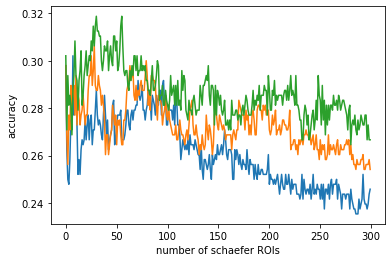

In [21]:
import matplotlib.pyplot as plt
_=plt.plot(schaeferAcc[:,0])
_=plt.plot(schaeferAcc[:,1])
_=plt.plot(schaeferAcc[:,2])
_=plt.xlabel("number of schaefer ROIs")
_=plt.ylabel("accuracy")

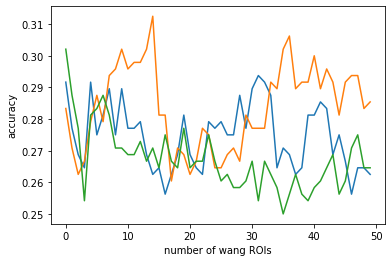

In [22]:
_=plt.plot(wangAcc[:,0])
_=plt.plot(wangAcc[:,1])
_=plt.plot(wangAcc[:,2])
_=plt.xlabel("number of wang ROIs")
_=plt.ylabel("accuracy")

In [35]:
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
from glob import glob
subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "
    
subjects

'1206161 0119173 1206162 1201161 0115174 1130161 1206163 0120171 0111171 1202161 1121161 0125172 0110172 0123173 0120172 0113171 0115172 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0119171 0117171 0119174 0112173 0112174 0125171 0112172 '

{'whiskers': [<matplotlib.lines.Line2D at 0x2b88af349438>,
 'caps': [<matplotlib.lines.Line2D at 0x2b88af342da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b88af3496a0>,
 'medians': [<matplotlib.lines.Line2D at 0x2b88af342470>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b88af33ec88>,
 'means': []}

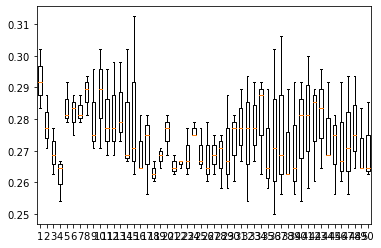

In [39]:
plt.boxplot(wangAcc.T)

['1206161',
 '0119173',
 '1206162',
 '1201161',
 '0115174',
 '1130161',
 '1206163',
 '0120171',
 '0111171',
 '1202161',
 '1121161',
 '0125172',
 '0110172',
 '0123173',
 '0120172',
 '0113171',
 '0115172',
 '0120173',
 '0110171',
 '0119172',
 '0124171',
 '0123171',
 '1203161',
 '0118172',
 '0118171',
 '0112171',
 '1207162',
 '0119171',
 '0117171',
 '0119174',
 '0112173',
 '0112174',
 '0125171',
 '0112172']

In [81]:
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
from glob import glob
from subprocess import call
import nib,os
subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]

testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs


for curr_roi in range(1,1+25):
    mask=[]
    command="fslmaths "
    for sub in subjects:
        file=f"./wang2014/{sub}/output/STAND_top{curr_roi}mask.nii.gz"
        path="/gpfs/milgram/project/turk-browne/projects/rtTest/"
        if os.path.exists(path+file):
            command=command+file+" -add "

    command=command[:-6]
    command=command+f' ./wang2014/sumMask_{curr_roi}.nii.gz'
    if curr_roi==2:
        print(command)
        call(command,shell=True)


fslmaths ./wang2014/1206161/output/STAND_top1mask.nii.gz -add ./wang2014/0119173/output/STAND_top1mask.nii.gz -add ./wang2014/1206162/output/STAND_top1mask.nii.gz -add ./wang2014/0115174/output/STAND_top1mask.nii.gz -add ./wang2014/1130161/output/STAND_top1mask.nii.gz -add ./wang2014/1206163/output/STAND_top1mask.nii.gz -add ./wang2014/0120171/output/STAND_top1mask.nii.gz -add ./wang2014/0111171/output/STAND_top1mask.nii.gz -add ./wang2014/1202161/output/STAND_top1mask.nii.gz -add ./wang2014/0125172/output/STAND_top1mask.nii.gz -add ./wang2014/0110172/output/STAND_top1mask.nii.gz -add ./wang2014/0123173/output/STAND_top1mask.nii.gz -add ./wang2014/0120172/output/STAND_top1mask.nii.gz -add ./wang2014/0113171/output/STAND_top1mask.nii.gz -add ./wang2014/0120173/output/STAND_top1mask.nii.gz -add ./wang2014/0110171/output/STAND_top1mask.nii.gz -add ./wang2014/0119172/output/STAND_top1mask.nii.gz -add ./wang2014/0124171/output/STAND_top1mask.nii.gz -add ./wang2014/0123171/output/STAND_top1m

fslmaths ./wang2014/1206161/output/STAND_top7mask.nii.gz -add ./wang2014/0119173/output/STAND_top7mask.nii.gz -add ./wang2014/1206162/output/STAND_top7mask.nii.gz -add ./wang2014/0115174/output/STAND_top7mask.nii.gz -add ./wang2014/1130161/output/STAND_top7mask.nii.gz -add ./wang2014/1206163/output/STAND_top7mask.nii.gz -add ./wang2014/0120171/output/STAND_top7mask.nii.gz -add ./wang2014/0111171/output/STAND_top7mask.nii.gz -add ./wang2014/1202161/output/STAND_top7mask.nii.gz -add ./wang2014/0125172/output/STAND_top7mask.nii.gz -add ./wang2014/0110172/output/STAND_top7mask.nii.gz -add ./wang2014/0123173/output/STAND_top7mask.nii.gz -add ./wang2014/0120172/output/STAND_top7mask.nii.gz -add ./wang2014/0113171/output/STAND_top7mask.nii.gz -add ./wang2014/0120173/output/STAND_top7mask.nii.gz -add ./wang2014/0110171/output/STAND_top7mask.nii.gz -add ./wang2014/0119172/output/STAND_top7mask.nii.gz -add ./wang2014/0124171/output/STAND_top7mask.nii.gz -add ./wang2014/0123171/output/STAND_top7m

fslmaths ./wang2014/1206161/output/STAND_top15mask.nii.gz -add ./wang2014/0119173/output/STAND_top15mask.nii.gz -add ./wang2014/1206162/output/STAND_top15mask.nii.gz -add ./wang2014/0115174/output/STAND_top15mask.nii.gz -add ./wang2014/1130161/output/STAND_top15mask.nii.gz -add ./wang2014/1206163/output/STAND_top15mask.nii.gz -add ./wang2014/0120171/output/STAND_top15mask.nii.gz -add ./wang2014/0111171/output/STAND_top15mask.nii.gz -add ./wang2014/1202161/output/STAND_top15mask.nii.gz -add ./wang2014/0125172/output/STAND_top15mask.nii.gz -add ./wang2014/0110172/output/STAND_top15mask.nii.gz -add ./wang2014/0123173/output/STAND_top15mask.nii.gz -add ./wang2014/0120172/output/STAND_top15mask.nii.gz -add ./wang2014/0113171/output/STAND_top15mask.nii.gz -add ./wang2014/0120173/output/STAND_top15mask.nii.gz -add ./wang2014/0110171/output/STAND_top15mask.nii.gz -add ./wang2014/0119172/output/STAND_top15mask.nii.gz -add ./wang2014/0124171/output/STAND_top15mask.nii.gz -add ./wang2014/0123171/

fslmaths ./wang2014/1206161/output/STAND_top24mask.nii.gz -add ./wang2014/0119173/output/STAND_top24mask.nii.gz -add ./wang2014/1206162/output/STAND_top24mask.nii.gz -add ./wang2014/0115174/output/STAND_top24mask.nii.gz -add ./wang2014/1130161/output/STAND_top24mask.nii.gz -add ./wang2014/1206163/output/STAND_top24mask.nii.gz -add ./wang2014/0120171/output/STAND_top24mask.nii.gz -add ./wang2014/0111171/output/STAND_top24mask.nii.gz -add ./wang2014/1202161/output/STAND_top24mask.nii.gz -add ./wang2014/0125172/output/STAND_top24mask.nii.gz -add ./wang2014/0110172/output/STAND_top24mask.nii.gz -add ./wang2014/0123173/output/STAND_top24mask.nii.gz -add ./wang2014/0120172/output/STAND_top24mask.nii.gz -add ./wang2014/0113171/output/STAND_top24mask.nii.gz -add ./wang2014/0120173/output/STAND_top24mask.nii.gz -add ./wang2014/0110171/output/STAND_top24mask.nii.gz -add ./wang2014/0119172/output/STAND_top24mask.nii.gz -add ./wang2014/0124171/output/STAND_top24mask.nii.gz -add ./wang2014/0123171/

In [83]:

for curr_roi in range(1,1+300):
    mask=[]
    command="fslmaths "
    for sub in subjects:
        file=f"./schaefer2018/{sub}/output/STAND_top{curr_roi}mask.nii.gz"
        path="/gpfs/milgram/project/turk-browne/projects/rtTest/"
        if os.path.exists(path+file):
            command=command+file+" -add "

    command=command[:-6]
    command=command+f' ./schaefer2018/sumMask_{curr_roi}.nii.gz'
    if curr_roi==2:
        print(command)
        call(command,shell=True)


fslmaths ./schaefer2018/1206161/output/STAND_top2mask.nii.gz -add ./schaefer2018/0119173/output/STAND_top2mask.nii.gz -add ./schaefer2018/1206162/output/STAND_top2mask.nii.gz -add ./schaefer2018/0115174/output/STAND_top2mask.nii.gz -add ./schaefer2018/1130161/output/STAND_top2mask.nii.gz -add ./schaefer2018/1206163/output/STAND_top2mask.nii.gz -add ./schaefer2018/0120171/output/STAND_top2mask.nii.gz -add ./schaefer2018/0111171/output/STAND_top2mask.nii.gz -add ./schaefer2018/0110172/output/STAND_top2mask.nii.gz ./schaefer2018/sumMask_2.nii.gz


In [74]:
fslview_deprecated ./schaefer2018/sumMask_1.nii.gz /gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz 
fslview_deprecated ./schaefer2018/sumMask_2.nii.gz /gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz 


True

In [84]:
sub="0110171"
TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_1.nii.gz"
WANGINFUNC=f"./wang2014/{sub}/wanginfunc.nii.gz"
print(f"fslview_deprecated {TEMPLATE} {WANGINFUNC}")


fslview_deprecated /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/realtime_preprocessed/0110171_neurosketch_recognition_run_1.nii.gz ./wang2014/0110171/wanginfunc.nii.gz


In [ ]:
fslview_de /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/1206161_neurosketch/data/nifti/realtime_preprocessed/1206161_neurosketch_recognition_run_1.nii.gz ./wang2014/1206161/wanginfunc.nii.gz